In [1]:
from datetime import datetime
import time

import gdax
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
NUM_LEVELS = 256
SZ = int(2e5)
INITIAL_WAIT = 10
TIME_STEP = 0.5
C_CHECKPOINTS = 100

In [3]:
class OrderBookInmensus(gdax.OrderBook):
    def __init__(self, product_id='BTC-USD', log_to=None):
        super(OrderBookInmensus, self).__init__(product_id=product_id)
        
    def on_open(self):
        self._sequence = -1
        print("-- Subscribed to OrderBook(Inmensus)! --\n")
        
    def on_error(self, e, data=None):
        self.error = e
        self.stop = True
        print('Error: {} - data: {}'.format(e, data))
        

In [4]:
order_book = OrderBookInmensus(product_id='BTC-USD')

In [5]:
order_book.start()
time.sleep(INITIAL_WAIT)
order_book.close()

-- Subscribed to OrderBook(Inmensus)! --


-- OrderBook Socket Closed! --


In [6]:
order_book.get_current_book()['bids'][-1]

[Decimal('6099.57000000'),
 Decimal('0.00127000'),
 '7becd8d7-a95e-4159-b5d5-7aca0b3841b3']

Wall time: 136 ms


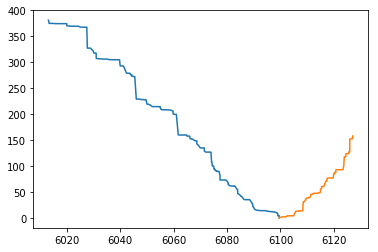

In [7]:
%%time
def aggregate(orders, is_bid):
    dfreq = {}
    for dp, dv, _ in orders:
        sp = str(dp)
        v = np.float(dv)
        if sp in dfreq:
            dfreq[sp] += v
        else:
            dfreq[sp] = v
    
    lfreq = list(dfreq.items())
    lfreq = [(np.float(p), v) for p, v in lfreq]
    lfreq.sort()
    
    if is_bid:
        return np.asarray(lfreq[-NUM_LEVELS:])
    else:
        return np.asarray(lfreq[:NUM_LEVELS])

def get_vols(order_book):
    cur_book = order_book.get_current_book()
    bid_vols = aggregate(cur_book['bids'], True)
    ask_vols = aggregate(cur_book['asks'], False)
    return bid_vols, ask_vols

bv, av = get_vols(order_book)
plt.plot(bv[:, 0], bv[:, 1].sum() - bv[:, 1].cumsum())
plt.plot(av[:, 0], av[:, 1].cumsum())

In [8]:
bid_record = np.zeros((SZ, NUM_LEVELS, 2))
ask_record = np.zeros((SZ, NUM_LEVELS, 2))
time_record = np.zeros(SZ)
print("Will last", SZ / 60.0 / 60 / 2, "hours")

Will last 27.77777777777778 hours


In [9]:
def record_order_book(idx, order_book, t):
    bv, av = get_vols(order_book)
    bid_record[idx] = bv
    ask_record[idx] = av
    time_record[idx] = t

In [10]:
%%time
record_order_book(0, order_book, time.time())

Wall time: 119 ms


In [11]:
order_book.start()
print("Doing initial sleep...")
time.sleep(INITIAL_WAIT)
print("Collecting data...")

print("Recording order_book every {} seconds for {} seconds".format(TIME_STEP, SZ / 2))
per_checkpoint = SZ // C_CHECKPOINTS
try:
    idx = 0
    for idx in range(SZ):
        beg_time = time.time()
        
        #in case of error, make sure the order_book is still open
        if order_book.stop:
            print("Orderbook is stopped, restarting...")
            order_book.start()
            print("Doing initial sleep...")
            time.sleep(INITIAL_WAIT)
            print("Collecting data...")
        
        record_order_book(idx, order_book, time.time())
        
        #logging
        print("\r", bid_record[idx,-5:,0], ask_record[idx,-5:,0], time.time() - beg_time, end="")
        if idx % per_checkpoint == 0:
            print()
        
        end_time = time.time()
        elapsed_time = end_time - beg_time
        time.sleep(max(TIME_STEP - elapsed_time, 0))
        
except KeyboardInterrupt as e:
    order_book.close()
    raise(e)

-- Subscribed to OrderBook(Inmensus)! --

Doing initial sleep...
Recording order_book every 0.5 seconds for 100000.0 seconds
 [6098.82 6098.99 6099.02 6099.03 6099.57] [6126.79 6126.99 6127.12 6127.17 6127.19] 0.11095499992370605
 [6107.03 6107.04 6107.12 6107.31 6107.33] [6128.58 6128.59 6128.6  6128.66 6128.67] 0.09307241439819336
 [6107.88 6108.   6108.5  6108.55 6108.69] [6128.83 6128.88 6128.9  6128.93 6129.17] 0.09303927421569824Error: Connection is already closed. - data: None

-- OrderBook Socket Closed! --
 [6107.88 6108.   6108.5  6108.55 6108.69] [6128.83 6128.88 6128.9  6128.93 6129.17] 0.1086580753326416Orderbook is stopped, restarting...
-- Subscribed to OrderBook(Inmensus)! --

Doing initial sleep...
 [6107.74 6107.84 6107.88 6108.   6108.95] [6128.39 6128.4  6128.45 6128.46 6128.58] 0.09306383132934576
 [6100.   6102.   6106.29 6107.   6107.07] [6129.17 6129.19 6129.2  6129.28 6129.33] 0.09309530258178711
 [6104.04 6104.55 6106.64 6106.69 6106.7 ] [6127.79 6127.83 6127.

 [5891.4  5891.41 5894.2  5894.99 5895.38] [6030.33 6030.41 6030.51 6033.28 6035.  ] 0.13056302070617676
 [5877.77 5877.78 5880.   5880.01 5880.02] [5989.76 5990.   5990.02 5992.62 5992.82] 0.11132812523913574
 [5874.38 5875.   5875.7  5875.74 5876.33] [5975.   5975.78 5976.   5977.16 5977.86] 0.10933423042297363
 [5883.46 5883.48 5883.49 5884.19 5887.39] [6009.73 6010.   6011.03 6012.41 6012.5 ] 0.11128139495849616
 [5878.74 5880.   5880.85 5880.86 5881.69] [5999.   5999.   5999.95 5999.97 5999.99] 0.11126136779785156
 [5871.72 5873.53 5874.45 5874.99 5875.  ] [5985.   5985.34 5987.   5987.5  5989.  ] 0.33808636665344243
 [5873.   5873.04 5873.05 5873.83 5873.92] [5980.01 5980.02 5980.1  5981.47 5982.14] 0.39717626571655273
 [5877.   5877.7  5878.   5879.   5879.99] [5997.   5997.07 5998.   5998.   5999.  ] 0.370003223419189451.0117385387420654
 [5866.5  5866.61 5866.66 5866.84 5869.56] [5965.74 5966.62 5966.66 5966.98 5967.05] 0.35104703903198245
 [5872.97 5874.   5874.43 5874.52 587

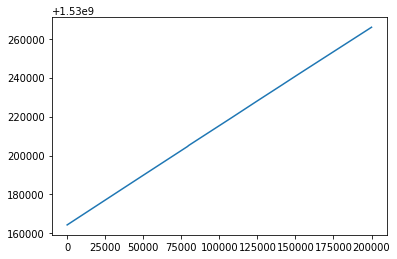

In [12]:
plt.plot(time_record)

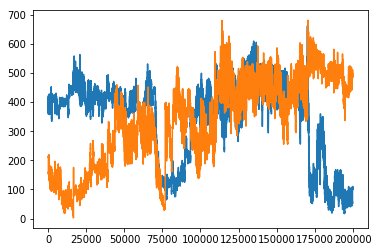

In [13]:
plt.plot(bid_record[:,:,1].sum(axis=1))
plt.plot(ask_record[:,:,1].sum(axis=1))

In [15]:
np.save('data/bid-record.npy', bid_record)
np.save('data/ask-record.npy', ask_record)
np.save('data/time-record.npy', time_record)